In [1]:
# Setup the library
import pyrogue.utilities.fileio as fileio
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import struct
from scipy.stats import norm
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
top_level=f'{os.getcwd()}/..'

In [2]:
def datfile(filename):
    # Waveforms variables to be filled 
    ampFault = { i : []  for i in range(4) }  
    xPosFault = []
    yPosFault = []
    qBunchFault = []
    recordtime = []
    
    # Open the .dat file
    with fileio.FileReader(files=f'{top_level}/datfile/'+filename) as fd:
        
        # Loop through the file data
        for header,data in fd.records():
    
            # Check if there is a 8-byte header in the frame
            if (header.flags==0):
                hdrOffset = 8
                hdr = struct.unpack("<d", data[:8])[0]
                timestamp = time.localtime(hdr)
                # Define the desired format string (replace with your preferred format)
                # Some common format specifiers:
                # %Y - Year with century
                # %m - Month as a decimal number (01-12)
                # %d - Day of the month as a decimal number (01-31)
                # %H - Hour in 24-hour format (00-23)
                # %M - Minute (00-59)
                # %S - Second (00-59)
                
                formatted_time = time.strftime('%Y-%m-%d_%H-%M-%S', timestamp)
                #print( f'CH={header.channel}: Event Timestamp in human-readable format: {formatted_time}' )
                if header.channel==24:
                    recordtime.append(formatted_time)
            
            else:
                hdrOffset = 0
                print( 'No timestamp header detected' )
            
            # Check for error in frame
            if (header.error>0):
                # Look at record header data
                print(f"Processing record. Total={fd.totCount}, Current={fd.currCount}")
                print(f"Record size    = {header.size}")
                print(f"Record channel = {header.channel}")
                print(f"Record flags   = {header.flags:#x}")
                print(f"Record error   = {header.error:#x}")
    
            # Check if AMP Fault waveform
            elif (header.channel < 16) and (header.channel >= 12):
                ampFault[header.channel-12].append(data[hdrOffset:].view(np.int16))
    
            # Check if AMP Live waveform
            elif header.channel == 24:
                fpData = data[hdrOffset:].view(np.float32)
                fpDataLen = len(fpData)
                xPosFault.append(   fpData[0:(fpDataLen*3)+0:3] ) 
                yPosFault.append(   fpData[1:(fpDataLen*3)+1:3] )
                qBunchFault.append( fpData[2:(fpDataLen*3)+2:3] )
            
            # Else undefined stream index
            else:
                print( f'UNDEFINED DATA STREAM[{header.channel}]!!!')
    return ampFault, recordtime

In [50]:
def make_heatmap(filename,eventnum,normalize,lim):
    ampFault, recordtime=datfile(filename)
    print(f'Recorded time : {recordtime}')
    print(f'Selected time : {recordtime[eventnum]}')
    
    def bunchindex(threshold,waveform):
        start=12800
        firstbunch=0
        for i in range(1,8*2000):
            if waveform[start+i-1]<waveform[start+i] and waveform[start+i]>waveform[start+i+1]:
                if waveform[start+i]>threshold:
                    firstbunch=start+i
                    break
        if firstbunch==0:
            print("data is not invalid")
            return firstbunch, 0
    
        bunch_candidate=waveform[firstbunch:firstbunch+5120*8:8]
        bunch_index=np.where(bunch_candidate>threshold)[0]
    
        return firstbunch, bunch_index

    firstbunch, bunch_index=bunchindex(1000,ampFault[0][eventnum])
    if firstbunch==0:
        print("end process")
        return
    
    print(f'Num of bunch : {len(bunch_index)}')
    print(f'First bunch index : {firstbunch}')
    start=12800
    y_pos=[]
    charge=[]
    for j in bunch_index:
        certain_bunch=[]
        certain_bunch_charge=[]
        for i in range(12):
            sum=ampFault[0][eventnum][firstbunch+j*8+5120*8*i]
            delta=ampFault[1][eventnum][firstbunch+j*8+5120*8*i]
            yposition=delta/sum*16.58/5+1.6
            certain_bunch.append(yposition)
            certain_bunch_charge.append(sum)
        y_pos.append(np.array(certain_bunch))
        charge.append(np.array(certain_bunch_charge))
    y_pos=np.array(y_pos)
    charge=np.array(charge)


    if normalize:
        mean=np.mean(y_pos[:,0:2],axis=1)
        y_pos=y_pos-mean[:,np.newaxis]

    if normalize:
        charge_mean=np.mean(charge[:,0:3],axis=1)
        charge=charge/charge_mean[:,np.newaxis]


   
    #make x axis
    bunch_index_2=[]
    for i in range(2):
        bunch_index_2.append(bunch_index+5120*i)

    x_axis=np.concatenate(bunch_index_2)*1/509-5

    
    fig, (ax1) = plt.subplots(1, 1, sharex=True,figsize=(6,3))


    #ax1.set_title(f'{recordtime[0]}   Nb={len(bunch_index)}')
    ax1.scatter(x_axis,np.concatenate((y_pos[:,10],y_pos[:,11])),color='red',s=10)
    ax1.set_ylabel("Y position (mm)")
    #ax1.set_ylim(-2,2)
    #if normalize:
    #    ax1.set_ylim(-0.4,1)
    ax1.set_ylim(-0.2,0.4)
    ax1.grid()
    #ax1.text(0.05,0.05,'Upstream Vertical',transform=ax1.transAxes,ha='left',va='bottom',fontsize=20)
    #for i in range(12):
    #    ax1.vlines(i+1,-2,2,color='black')
    #ax1.hlines(0,1,13,color='black')
    #ax1.set_xticks([11,12])


    #ax2.bar(x,np.concatenate(split).reshape(len(x)),width=1/len(bunch_index),color='black')
    #ax2.scatter(x_axis,np.concatenate((charge[:,10],charge[:,11])),color='blue',s=6)
    #ax2.set_xlabel("time (us)")
    #ax2.set_ylabel("Charge")
    #ax2.set_ylim(0,1.2)
    #ax2.grid()
    #for i in range(12):
    #    ax2.vlines(i+1,-2,2,color='black')
    #ax2.hlines(1,1,13,color='black')
    #ax2.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13],['1','2','3','4','5','6','7','8','9','10','11','12','abort'])
    #ax2.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax1.set_xlim(0,4.8)
    #ax2.text(0.05,0.05,'Upstream Charge',transform=ax2.transAxes,ha='left',va='bottom',fontsize=20)


    #plt.subplots_adjust(hspace=.1)
    plt.savefig("beamloss2.png",dpi=200)
    plt.show()

Recorded time : ['2024-03-08_02-20-35', '2024-03-08_03-58-25']
Selected time : 2024-03-08_03-58-25
Num of bunch : 783
First bunch index : 13601


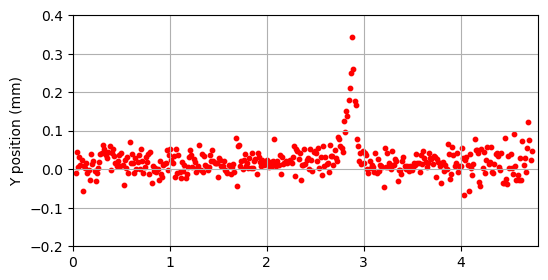

In [51]:
make_heatmap('data_20240307_191034.dat',1
             ,True,8)